 # 3.3 MNIST Handwritten Digits

In [1]:
import os

import numpy as np

from matplotlib import pyplot as plt

from keras.datasets import mnist
from keras.layers import *
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy
from keras import backend as K
from keras.backend.tensorflow_backend import set_session

import tensorflow as tf

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

# GPU memory usage
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.07
set_session(tf.Session(config=config))

plt.style.use('seaborn-darkgrid')

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Define Class

In [2]:
class PPAN:

    def __init__(self,
                 img_size=(28, 28),
                 channels=1,
                 noise_dim=20,
                 learning_rates=[2e-4, 2e-4, 1e-3],
                 utility_weight=2,
                 valid_weight=1):
        '''
        Build PPAN model
        Args:
            img_size: tuple, input image size, default=(28, 28)
            channels: int, input image channels, default=1
            noise_dim: int, noise input of mechanism network, default=20
            learning_rates: list, list of learning rates of adversary, discriminator and mechanism, default=[1e-4, 1e-4, 1e-3]
            utility_weight: float, weight of the utility loss, default=2
            valid_weight: float, weight of the discriminator loss, default=1
        Returns:
            PPAN object
        '''
        # Get variables
        self.img_size = img_size
        self.channels = channels
        self.noise_dim = noise_dim
        self.utility_weight = utility_weight
        self.valid_weight = valid_weight
        
        # Get networks
        self.mechanism = self.build_mechanism()
        self.adversary = self.build_adversary()
        self.discriminator = self.build_discriminator()
        
        # Setup optimizers
        a_optimizer = SGD(learning_rates[0])
        d_optimizer = SGD(learning_rates[1])
        m_optimizer = Adam(learning_rates[2], 0.5)
        
        # Compile discriminators
        self.adversary.compile(
            loss=self.negative_mutual_info_privacy_loss,
            optimizer=a_optimizer,
            weighted_metrics=["accuracy"])
        self.discriminator.compile(
            loss="binary_crossentropy",
            optimizer=d_optimizer,
            weighted_metrics=["accuracy"])
        
        # Combined two discriminators with the mechanism(generator)
        noised_img = Input(
            shape=(self.img_size[0] * self.img_size[1] + self.noise_dim,))
        gen_img = self.mechanism(noised_img)
        
        # Freeze discriminators
        self.adversary.trainable = False
        self.discriminator.trainable = False
        
        # Get predictions from discriminators
        pred_label = self.adversary(gen_img)
        pred_valid = self.discriminator(gen_img)
        self.ppan = Model(
            inputs=noised_img, outputs=[pred_label, gen_img, pred_valid])
        
        # Compile mechanism
        self.ppan.compile(
            loss=[
                self.mutual_info_privacy_loss,
                "binary_crossentropy",
                "binary_crossentropy"
            ],
            loss_weights=[1.0, self.utility_weight, self.valid_weight],
            optimizer=m_optimizer)

    def mutual_info_privacy_loss(self, y_true, y_pred):
        conditional_entropy = -K.mean(
            K.sum(K.log(y_pred + 1e-9) * y_true, axis=1))  # K.sum(axis=1) turn the vector into scalar
        return conditional_entropy
    
    def negative_mutual_info_privacy_loss(self, y_true, y_pred):
        conditional_entropy = -K.mean(
            K.sum(K.log(y_pred + 1e-9) * y_true, axis=1))  # K.sum(axis=1) turn the vector into scalar
        return -conditional_entropy

    def build_mechanism(self):
        model = Sequential(name="Mechanism")

        model.add(
            Dense(
                1000,
                activation="tanh",
                input_dim=self.img_size[0] * self.img_size[1] * self.channels +
                self.noise_dim,
                name="fc1"))
        model.add(Dense(1000, activation="tanh", name="fc2"))
        model.add(Dense(self.img_size[0] * \
                        self.img_size[1], activation="sigmoid", name="output"))

        print("\n=== Mechanism Summary ===")
        model.summary()

        return model

    def build_adversary(self):
        model = Sequential(name="Adversary")

        model.add(
            Dense(
                1000,
                activation="tanh",
                input_dim=self.img_size[0] * self.img_size[1] * self.channels,
                name="fc1"))
        model.add(Dense(1000, activation="tanh", name="fc2"))
        model.add(Dense(10, activation="softmax", name="output"))

        print("\n=== Adversary Summary ===")
        model.summary()

        return model

    def build_discriminator(self):
        model = Sequential(name="Discriminator")

        model.add(
            Dense(
                500,
                activation="tanh",
                input_dim=self.img_size[0] * self.img_size[1] * self.channels,
                name="fc1"))
        model.add(Dense(1, activation="sigmoid", name="output"))

        print("\n=== Discriminator Summary ===")
        model.summary()

        return model

    def train(self,
              x_train,
              y_train,
              x_test,
              y_test,
              epochs,
              batch_size,
              save_path,
              print_interval=10,
              save_interval=50):
        '''
        Train model
        Args:
            x_train: ndarray, training images
            y_train: ndarray, training labels
            x_test: ndarray, testing images
            y_test: ndarray, testing labels
            epochs: int, training epochs
            batch_size: int, training batch size
            save_path: string, saving path for generated images during training process
            print_interval: int, print accuracy & loss every print_interval epochs, default=10
            save_interval: int, save generated images every save_interval, default=50
        Returns:
            None
        '''
        # Flatten images data
        x_train = x_train.reshape(
            (x_train.shape[0],
             self.img_size[0] * self.img_size[1] * self.channels))
        x_train = x_test.reshape(
            (x_test.shape[0],
             self.img_size[0] * self.img_size[1] * self.channels))
        # Set labels for discriminator
        valid = np.ones(shape=(batch_size, 1))
        fake = np.zeros(shape=(batch_size, 1))
        # Store training loss and accuracy in an array
        # privacy/realistic/utility loss (a/d/m networks)
        self.losses = np.zeros(shape=(epochs, 3))
        # adversary/discriminator accuracy
        self.accuracies = np.zeros(shape=(epochs, 2))
        # Training
        for e in range(epochs):
            # -------------------------
            # Train Discriminators
            # -------------------------
            # Random sample batch_size images from data
            idx = np.random.randint(
                low=0, high=x_train.shape[0], size=batch_size)
            original_imgs, labels = x_train[idx], y_train[idx]
            # Sample noise and generate a batch of new images
            noise = np.random.uniform(
                low=-1, high=1, size=(batch_size, self.noise_dim))
            gen_imgs = self.mechanism.predict(np.hstack((original_imgs, noise)))
            # Train adversary
            self.losses[e, 0], self.accuracies[
                e, 0] = self.adversary.train_on_batch(gen_imgs, labels)
            # Train discriminator
            d_loss_valid = self.discriminator.train_on_batch(
                original_imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            self.losses[e, 1], self.accuracies[e, 1] = 0.5 * \
                np.add(d_loss_valid, d_loss_fake)
            # -------------------------
            # Train Generator
            # -------------------------
            # Sample batch_size images and noise
            idx = np.random.randint(
                low=0, high=x_train.shape[0], size=batch_size)
            original_imgs, labels = x_train[idx], y_train[idx]
            noise = np.random.uniform(
                low=-1, high=1, size=(batch_size, self.noise_dim))
            # Train mechanism
            m_loss = self.ppan.train_on_batch(
                np.hstack((original_imgs, noise)),
                [labels, original_imgs, valid])
            self.losses[e, 2] = m_loss[0] + m_loss[
                1] * self.utility_weight + m_loss[2] * self.valid_weight

            # Print loss at the beginning/end and every print_interval
            # if (e+1 % print_interval == 0) or (e == 0) or (e+1 == epochs):
            print(
                "%dth epoch\tA loss: %.3f, acc: %.2f%%\tD loss: %.3f, acc: %.2f%%\tM privacy: %.3f, utility: %.3f, realistic: %.3f, weighted: %.3f"
                % (e + 1, self.losses[e, 0], self.accuracies[e, 0] * 100,
                   self.losses[e, 1], self.accuracies[e, 1] * 100, m_loss[0],
                   m_loss[1], m_loss[2], self.losses[e, 2]))
            # Generate images and save at the beginning/end and every save_interval


#             if e+1 % save_interval == 0 or e == 0 or e+1 == self.epochs:
#                 self.generate(self.noise, "%s%d.png" % (save_path, e))

#     def gen_noise(self):

#     def generate(self)


## Load Data

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

## Data Preprocessing

### Normalize

In [4]:
x_train = x_train / 255.0
x_test = x_test / 255.0

### One-Hot Encoded

In [5]:
Y_train = to_categorical(y_train, num_classes=10)
Y_test = to_categorical(y_test, num_classes=10)

## Main

### Build Model

In [6]:
ppan = PPAN(utility_weight=2, valid_weight=1)


=== Mechanism Summary ===
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc1 (Dense)                  (None, 1000)              805000    
_________________________________________________________________
fc2 (Dense)                  (None, 1000)              1001000   
_________________________________________________________________
output (Dense)               (None, 784)               784784    
Total params: 2,590,784
Trainable params: 2,590,784
Non-trainable params: 0
_________________________________________________________________

=== Adversary Summary ===
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc1 (Dense)                  (None, 1000)              785000    
_________________________________________________________________
fc2 (Dense)                  (None, 1000)              1001000   
____________

### Train Model

In [7]:
%%time
ppan.train(x_train, Y_train, x_test, Y_test, 1000, 32, save_path="generated/")

/opt/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1th epoch	A loss: -2.437, acc: 12.50%	D loss: 1.252, acc: 46.88%	M privacy: 4.045, utility: 2.493, realistic: 0.702, weighted: 9.734
2th epoch	A loss: -2.301, acc: 6.25%	D loss: 1.766, acc: 42.19%	M privacy: 3.669, utility: 2.273, realistic: 0.671, weighted: 8.886
3th epoch	A loss: -2.410, acc: 6.25%	D loss: 2.023, acc: 40.62%	M privacy: 3.762, utility: 2.473, realistic: 0.629, weighted: 9.336
4th epoch	A loss: -2.279, acc: 18.75%	D loss: 2.113, acc: 50.00%	M privacy: 3.660, utility: 2.488, realistic: 0.574, weighted: 9.210
5th epoch	A loss: -2.238, acc: 18.75%	D loss: 2.212, acc: 45.31%	M privacy: 3.281, utility: 2.216, realistic: 0.521, weighted: 8.234
6th epoch	A loss: -2.466, acc: 12.50%	D loss: 2.289, acc: 42.19%	M privacy: 3.411, utility: 2.440, realistic: 0.476, weighted: 8.768
7th epoch	A loss: -2.356, acc: 3.12%	D loss: 2.175, acc: 42.19%	M privacy: 3.322, utility: 2.445, realistic: 0.427, weighted: 8.640
8th epoch	A loss: -2.384, acc: 12.50%	D loss: 2.144, acc: 40.62%	M priva

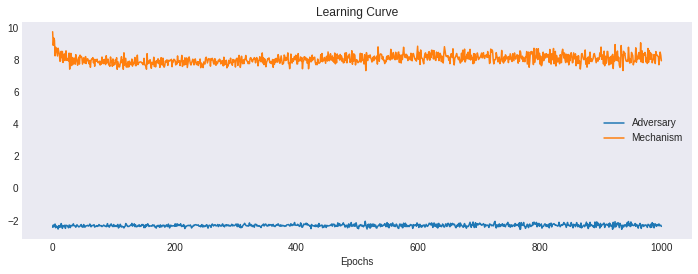

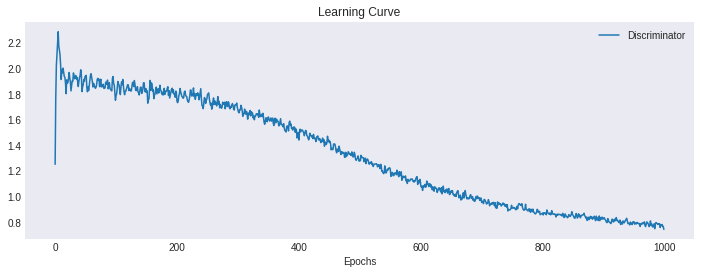

In [8]:
plt.style.use('seaborn-dark')  # have to call this function twice to make it work
plt.figure(figsize=(12, 4))
plt.plot(ppan.losses[:,0], label="Adversary")
plt.plot(ppan.losses[:,2], label="Mechanism")
plt.legend(loc='best')
plt.title("Learning Curve")
plt.xlabel("Epochs")
plt.show()

plt.style.use('seaborn-dark')  # have to call this function twice to make it work
plt.figure(figsize=(12, 4))
plt.plot(ppan.losses[:,1], label="Discriminator")
plt.legend(loc='best')
plt.title("Learning Curve")
plt.xlabel("Epochs")
plt.show()

## Testing

In [9]:
test_sample = [1,3,5,7,2,0,13,15,17,19]

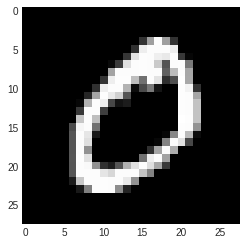

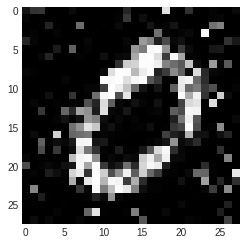

0


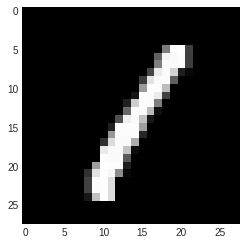

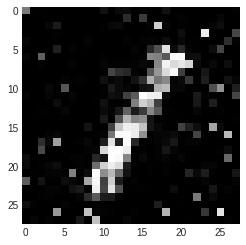

1


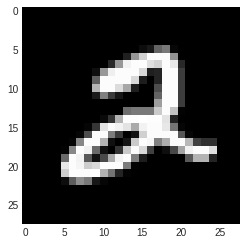

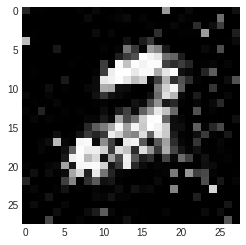

2


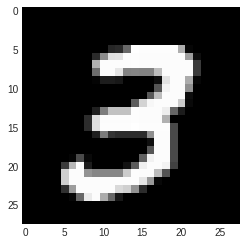

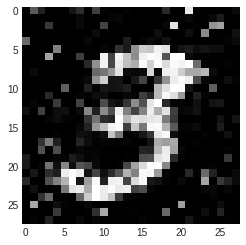

3


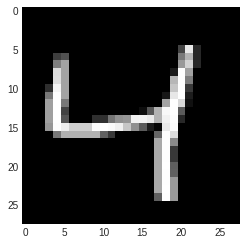

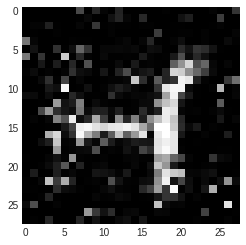

4


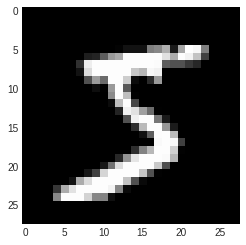

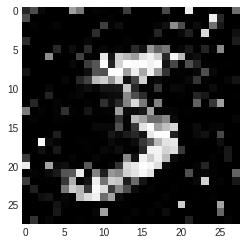

5


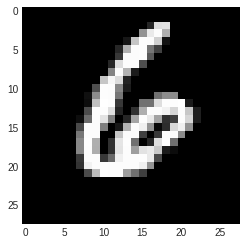

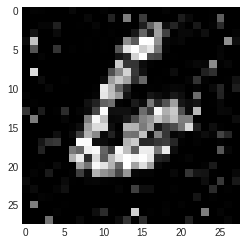

6


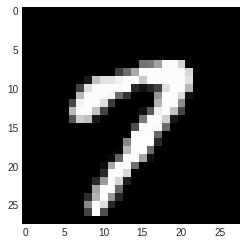

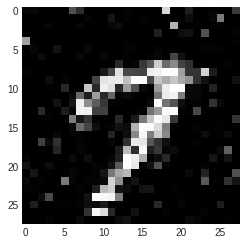

7


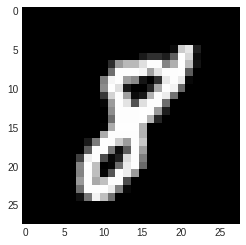

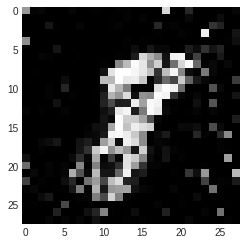

8


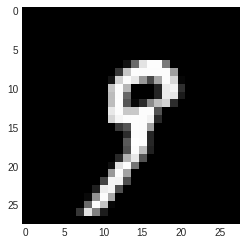

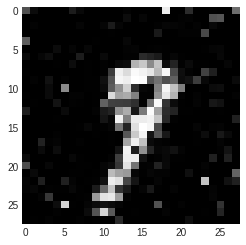

9


In [10]:
for i in test_sample:
    test_img = x_train[i].reshape((1, 784))
    test_noise = np.random.uniform(low=-1, high=1, size=(1, 20))

    test_result = ppan.mechanism.predict(np.hstack((test_img, test_noise))).reshape((28, 28))

    plt.imshow(test_img.reshape((28, 28)), cmap="gray")
    plt.show()
    plt.imshow(test_result, cmap="gray")
    plt.show()
    print(y_train[i])